In [2]:
import torch
print(torch.cuda.is_available())         # should return True
print(torch.cuda.get_device_name(0))     # should say "NVIDIA GeForce RTX 3060"


True
NVIDIA GeForce RTX 3060


IMPORTS

In [3]:

import IPython.display as ipd
import librosa
import noisereduce as nr
import numpy as np
import soundfile as sf
from pathlib import Path
import os
import torch
from torch.utils.data import Dataset
from glob import glob

import matplotlib.pyplot as plt
import IPython.display as ipd

import shutil
import pandas as pd
from sklearn.model_selection import train_test_split


In [ ]:
import os
import pandas as pd
import shutil
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

# Config
RANDOM_SEED = 42
BASE_DIR = "datasets/release_in_the_wild"
META_CSV = os.path.join(BASE_DIR, "meta.csv")
WAV_DIR = BASE_DIR

OUTPUT_DIRS = {
    "train": os.path.join(BASE_DIR, "train"),
    "val": os.path.join(BASE_DIR, "val"),
    "test": os.path.join(BASE_DIR, "test")
}

for path in OUTPUT_DIRS.values():
    os.makedirs(path, exist_ok=True)

df = pd.read_csv(META_CSV)
df["file"] = df["file"].str.strip()
df["label"] = df["label"].str.strip()
df["speaker"] = df["speaker"].str.strip()

df_40_percent, _ = train_test_split(
    df,
    train_size=0.4,
    random_state=RANDOM_SEED,
    stratify=df["label"]
)

train_df, temp_df = train_test_split(
    df_40_percent,
    test_size=0.30,
    random_state=RANDOM_SEED,
    stratify=df_40_percent["label"]
)

val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    random_state=RANDOM_SEED,
    stratify=temp_df["label"]
)

spoof_train = train_df[train_df["label"] == "spoof"]
bonafide_train = train_df[train_df["label"] == "bona-fide"]

spoof_upsampled = resample(
    spoof_train,
    replace=True,
    n_samples=len(bonafide_train),
    random_state=RANDOM_SEED
)

train_df = pd.concat([bonafide_train, spoof_upsampled]).sample(frac=1.0, random_state=RANDOM_SEED)

#copy not move 
def move_files(subset_df, split_name):
    for _, row in subset_df.iterrows():
        src = os.path.join(WAV_DIR, row["file"])
        dst = os.path.join(OUTPUT_DIRS[split_name], row["file"])
        os.makedirs(os.path.dirname(dst), exist_ok=True)
        if os.path.exists(src):
            shutil.copy(src, dst)

# Move files
#move_files(train_df, "train")
#move_files(val_df, "val")
#move_files(test_df, "test")

# Save metadata
train_df.to_csv(os.path.join(BASE_DIR, "train_meta.csv"), index=False)
val_df.to_csv(os.path.join(BASE_DIR, "val_meta.csv"), index=False)
test_df.to_csv(os.path.join(BASE_DIR, "test_meta.csv"), index=False)

# Summary
def count_files(folder_path):
    return len([f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))])

print("✔ 40% of dataset sampled and split into train/val/test (70/15/15).")
print("✔ Spoof samples oversampled in train set only.")
print(f"Train files: {count_files(OUTPUT_DIRS['train'])}")
print(f"Val files: {count_files(OUTPUT_DIRS['val'])}")
print(f"Test files: {count_files(OUTPUT_DIRS['test'])}")

# Show label distribution in each set
print("\nLabel Distribution:")
print("Train:\n", train_df["label"].value_counts())
print("Val:\n", val_df["label"].value_counts())
print("Test:\n", test_df["label"].value_counts())




✔ 40% of dataset sampled and split into train/val/test (70/15/15).
✔ Spoof samples oversampled in train set only.
Train files: 8246
Val files: 1907
Test files: 1907

Label Distribution:
Train:
 label
spoof        5589
bona-fide    5589
Name: count, dtype: int64
Val:
 label
bona-fide    1198
spoof         709
Name: count, dtype: int64
Test:
 label
bona-fide    1198
spoof         709
Name: count, dtype: int64


In [ ]:
import numpy as np
from pathlib import Path
from tqdm import tqdm


import librosa
from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift, Shift

# Preprocess raw audio
def preprocess_audio(y, sr, target_duration=6.0, apply_preemphasis=False, coef=0.5, normalise='rms'):
    y, _ = librosa.effects.trim(y)

    if apply_preemphasis:
        y = librosa.effects.preemphasis(y, coef=coef)

    if normalise == 'rms':
        rms = np.sqrt(np.mean(y**2))
        y = y / (rms + 1e-6)
    elif normalise == 'peak':
        y = y / (np.max(np.abs(y)) + 1e-6)

    target_length = int(sr * target_duration)
    if len(y) < target_length:
        y = np.pad(y, (0, target_length - len(y)))
    else:
        y = y[:target_length]

    return y


# Main extraction + saving
def extract_and_save_all(input_root, output_root, sr=22050, target_duration=6.0, apply_preemphasis=False, coef=0.5, normalise='rms'):
    input_root = Path(input_root)
    output_root = Path(output_root)

    for split in ["train", "val"]:  
        input_folder = input_root / split
        output_base = output_root / f"preprocessed_{split}"

        print(f"Looking in: {input_folder}")
        wav_files = [f for f in input_folder.glob("*.wav")]
        print(f"Found {len(wav_files)} files in '{split}'")

        for wav_file in tqdm(wav_files):
            try:
                y, _ = librosa.load(wav_file, sr=sr)
                y = preprocess_audio(y, sr, target_duration, apply_preemphasis, coef, normalise)

                base_name = wav_file.stem + ".npy"

                feature_dict = {
                    "mel_spectrogram": librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128),
                    "mfcc": librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20),
                    "chroma": librosa.feature.chroma_stft(y=y, sr=sr),
                    "tonnetz": librosa.feature.tonnetz(y=librosa.effects.harmonic(y), sr=sr),
                    "spectral_contrast": librosa.feature.spectral_contrast(y=y, sr=sr),
                    "spectral_centroid": librosa.feature.spectral_centroid(y=y, sr=sr),
                    "pitch": librosa.yin(y, fmin=50, fmax=300, sr=sr),
                    "energy": librosa.feature.rms(y=y),
                    "zcr": librosa.feature.zero_crossing_rate(y),
                    "onset_strength": librosa.onset.onset_strength(y=y, sr=sr)
                }

                for feature_name, data in feature_dict.items():
                    out_path = output_base / feature_name / base_name
                    out_path.parent.mkdir(parents=True, exist_ok=True)
                    np.save(out_path, data.astype(np.float32))

            except Exception as e:
                print(f"[ERROR] {wav_file.name}: {e}")

# Run the feature extraction
#extract_and_save_all("datasets/release_in_the_wild", "datasets/release_in_the_wild")





In [ ]:
def extract_and_save_all(input_root, output_root, sr=22050, target_duration=6.0,
                         apply_preemphasis=False, coef=0.5, normalise='rms'):
    input_root = Path(input_root)
    output_root = Path(output_root)

    splits = ["test"] 

    for split in splits:
        input_folder = input_root / split
        output_base = output_root / f"preprocessed_{split}"

        print(f"\nLooking in: {input_folder}")
        wav_files = sorted(input_folder.glob("*.wav"))
        print(f"Found {len(wav_files)} files in '{split}'")

        for wav_file in tqdm(wav_files):
            try:
                y, _ = librosa.load(wav_file, sr=sr)
                y = preprocess_audio(y, sr, target_duration, apply_preemphasis, coef, normalise)

                base_name = wav_file.stem + ".npy"

                feature_dict = {
                    "mel_spectrogram": librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128),
                    "mfcc": librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20),
                    "chroma": librosa.feature.chroma_stft(y=y, sr=sr),
                    "tonnetz": librosa.feature.tonnetz(y=librosa.effects.harmonic(y), sr=sr),
                    "spectral_contrast": librosa.feature.spectral_contrast(y=y, sr=sr),
                    "spectral_centroid": librosa.feature.spectral_centroid(y=y, sr=sr),
                    "pitch": librosa.yin(y, fmin=50, fmax=300, sr=sr),
                    "energy": librosa.feature.rms(y=y),
                    "zcr": librosa.feature.zero_crossing_rate(y),
                    "onset_strength": librosa.onset.onset_strength(y=y, sr=sr)
                }

                for feature_name, data in feature_dict.items():
                    out_path = output_base / feature_name / base_name
                    out_path.parent.mkdir(parents=True, exist_ok=True)
                    np.save(out_path, data.astype(np.float32))

            except Exception as e:
                print(f"[ERROR] {wav_file.name}: {e}")
                
#extract_and_save_all("datasets/release_in_the_wild", "datasets/release_in_the_wild")


In [7]:

def load_audio(path, sr=22050):
    y, _ = librosa.load(path, sr=sr)
    return y

def show_waveform(y, sr, title="Waveform"):
    plt.figure(figsize=(10, 2))
    librosa.display.waveshow(y, sr=sr)
    plt.title(title)
    plt.tight_layout()
    plt.show()

def show_mel_spectrogram(y, sr, title="Mel Spectrogram"):
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    mel_db = librosa.power_to_db(mel_spec, ref=np.max)

    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mel_db, sr=sr, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.tight_layout()
    plt.show()

def compare_audio(original_path, fake_path, apply_preprocessing=False, sr=22050):
    print(f" Original: {original_path}")
    y_real = load_audio(original_path, sr=sr)
    y_fake = load_audio(fake_path, sr=sr)

    if apply_preprocessing:
        y_real = preprocess_audio(y_real, sr, apply_preemphasis=True, normalise='rms')
        y_fake = preprocess_audio(y_fake, sr, apply_preemphasis=True, normalise='rms')

    # Waveform comparison
    show_waveform(y_real, sr, title="Real - Waveform")
    ipd.display(ipd.Audio(y_real, rate=sr))

    show_waveform(y_fake, sr, title="Fake - Waveform")
    ipd.display(ipd.Audio(y_fake, rate=sr))

    # Mel spectrogram comparison
    show_mel_spectrogram(y_real, sr, title="Real - Mel Spectrogram")
    show_mel_spectrogram(y_fake, sr, title="Fake - Mel Spectrogram")

real_audio_path = "datasets/release_in_the_wild/remaining_files/7.wav"

fake_audio_path = "datasets/release_in_the_wild/remaining_files/5.wav"

#compare_audio(real_audio_path, fake_audio_path, apply_preprocessing=False)

# compare_audio(real_audio_path, fake_audio_path, apply_preprocessing=True)




In [ ]:
import torch
from torch.utils.data import Dataset
import numpy as np
import os
import pandas as pd

import torch.nn.functional as F
class AudioFeatureDataset(Dataset):
    def __init__(self, meta_csv, feature_root,
                 features=['chroma', 'energy', 'mel_spectrogram', 'mfcc',
                           'onset_strength', 'pitch', 'spectral_centroid',
                           'spectral_contrast', 'tonnetz', 'zcr'],
                 target_shape=(128, 259)):  
        self.df = pd.read_csv(meta_csv)
        self.df["label"] = self.df["label"].str.strip().str.lower()
        self.feature_root = feature_root
        self.features = features
        self.label_map = {'bona-fide': 1, 'spoof': 0}
        self.target_shape = target_shape

    def __len__(self):
        return len(self.df)

    def pad_or_resize(self, tensor, target_shape):
        h, w = tensor.shape
        pad_h = target_shape[0] - h
        pad_w = target_shape[1] - w

        if pad_h < 0 or pad_w < 0:
            tensor = tensor[:target_shape[0], :target_shape[1]] 
        else:
            tensor = F.pad(tensor, (0, pad_w, 0, pad_h))  
        return tensor

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        file_id = os.path.splitext(row["file"])[0] + ".npy"
        label_raw = row["label"]
        if label_raw not in self.label_map:
            raise ValueError(f"Unknown label: '{label_raw}' at idx {idx}")
        label = self.label_map[label_raw]

        feature_arrays = []
        for feat in self.features:
            path = os.path.join(self.feature_root, feat, file_id) 
            if not os.path.exists(path):
                raise FileNotFoundError(f"Missing file: {path}")
            feature = np.load(path)
            tensor = torch.tensor(feature, dtype=torch.float32)
            if tensor.dim() == 1:
                tensor = tensor.unsqueeze(0)
            tensor = self.pad_or_resize(tensor, self.target_shape)
            feature_arrays.append(tensor)

        return (*feature_arrays, torch.tensor(label, dtype=torch.float32))



In [ ]:
import os
import numpy as np
import torch
import torch.nn.functional as F

feature_root = "datasets/release_in_the_wild/preprocessed_train"
features = ['chroma', 'energy', 'mel_spectrogram', 'mfcc',
            'onset_strength', 'pitch', 'spectral_centroid',
            'spectral_contrast', 'tonnetz', 'zcr']
target_shape = (128, 259)  

def pad_or_resize(tensor, target_shape):
    h, w = tensor.shape
    pad_h = target_shape[0] - h
    pad_w = target_shape[1] - w

    if pad_h < 0 or pad_w < 0:
        tensor = tensor[:target_shape[0], :target_shape[1]]
    else:
        tensor = F.pad(tensor, (0, pad_w, 0, pad_h))
    return tensor

for feat in features:
    folder_path = os.path.join(feature_root, feat)
    
    if not os.path.exists(folder_path):
        print(f"Folder not found: {folder_path}")
        continue

    file_list = os.listdir(folder_path)
    if not file_list:
        print(f"No files found in: {folder_path}")
        continue

    file_name = file_list[0]
    file_path = os.path.join(folder_path, file_name)
    
    try:
        arr = np.load(file_path)
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        continue

    print(f"\nFeature: {feat.upper()} ")
    print(f"File path: {file_path}")
    print(f"Raw .npy shape: {arr.shape}")

    tensor = torch.tensor(arr, dtype=torch.float32)

    if tensor.dim() == 1:
        tensor = tensor.unsqueeze(0)
        print(f"Tensor shape after unsqueeze: {tensor.shape}")
    
    processed_tensor = pad_or_resize(tensor, target_shape)
    print(f"Shape after pad_or_resize: {processed_tensor.shape}")

print("\nDone checking all feature folders.")



Feature: CHROMA 
File path: datasets/release_in_the_wild/preprocessed_train\chroma\1000.npy
Raw .npy shape: (12, 259)
Shape after pad_or_resize: torch.Size([128, 259])

Feature: ENERGY 
File path: datasets/release_in_the_wild/preprocessed_train\energy\1000.npy
Raw .npy shape: (1, 259)
Shape after pad_or_resize: torch.Size([128, 259])

Feature: MEL_SPECTROGRAM 
File path: datasets/release_in_the_wild/preprocessed_train\mel_spectrogram\1000.npy
Raw .npy shape: (128, 259)
Shape after pad_or_resize: torch.Size([128, 259])

Feature: MFCC 
File path: datasets/release_in_the_wild/preprocessed_train\mfcc\1000.npy
Raw .npy shape: (20, 259)
Shape after pad_or_resize: torch.Size([128, 259])

Feature: ONSET_STRENGTH 
File path: datasets/release_in_the_wild/preprocessed_train\onset_strength\1000.npy
Raw .npy shape: (259,)
Tensor shape after unsqueeze: torch.Size([1, 259])
Shape after pad_or_resize: torch.Size([128, 259])

Feature: PITCH 
File path: datasets/release_in_the_wild/preprocessed_train\p

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DenseNeuralNetwork(nn.Module):
    def __init__(self, input_dim, output_dim=128):
        super(DenseNeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.bn1 = nn.BatchNorm1d(256)

        self.fc2 = nn.Linear(256, 256)
        self.bn2 = nn.BatchNorm1d(256)

        self.fc3 = nn.Linear(256, output_dim)
        self.bn3 = nn.BatchNorm1d(output_dim)

        self.dropout = nn.Dropout(0.3)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = self.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = self.relu(self.bn3(self.fc3(x)))
        return x



class SiameseMFCCBranch(nn.Module):
    def __init__(self):
        super(SiameseMFCCBranch, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)

        self.pool = nn.MaxPool2d(2)
        self.dropout = nn.Dropout(0.5)

        self.flattened_size = 128 * 32 * 64  
        self.fc = nn.Linear(self.flattened_size, 128)

    def forward(self, x):
        x = F.relu(self.conv1(x))       
        x = self.pool(F.relu(self.conv2(x)))  
        x = self.pool(F.relu(self.conv3(x)))  
        x = self.dropout(x)
        x = x.view(x.size(0), -1)        
        x = self.fc(x)                   
        return x


# Final Fusion Model
class AudioDeepfakeFusionModel(nn.Module):
    def __init__(self):
        super(AudioDeepfakeFusionModel, self).__init__()

        self.mfcc_branch = SiameseMFCCBranch()

        self.chroma_branch = DenseNeuralNetwork(input_dim=128)
        self.tonnetz_branch = DenseNeuralNetwork(input_dim=128)
        self.contrast_branch = DenseNeuralNetwork(input_dim=128)
        self.pitch_branch = DenseNeuralNetwork(input_dim=128)
        self.energy_branch = DenseNeuralNetwork(input_dim=128)
        self.zcr_branch = DenseNeuralNetwork(input_dim=128)
        self.onset_branch = DenseNeuralNetwork(input_dim=128)
        self.centroid_branch = DenseNeuralNetwork(input_dim=128)
        self.mel_spec_branch = DenseNeuralNetwork(input_dim=128)

        self.fusion_layer = nn.Sequential(
            nn.Linear(10 * 128, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
        )
        self.output_layer = nn.Linear(256, 1)

    def forward(self, mfcc, chroma, tonnetz, contrast, pitch, energy, zcr, onset, centroid, mel_spec):
        mfcc = mfcc.unsqueeze(1)  

        def pool(x): return x.mean(dim=-1)  

        mfcc_out = self.mfcc_branch(mfcc)
        chroma_out = self.chroma_branch(pool(chroma))
        tonnetz_out = self.tonnetz_branch(pool(tonnetz))
        contrast_out = self.contrast_branch(pool(contrast))
        pitch_out = self.pitch_branch(pool(pitch))
        energy_out = self.energy_branch(pool(energy))
        zcr_out = self.zcr_branch(pool(zcr))
        onset_out = self.onset_branch(pool(onset))
        centroid_out = self.centroid_branch(pool(centroid))
        mel_spec_out = self.mel_spec_branch(pool(mel_spec))

        fusion = torch.cat([
            mfcc_out, chroma_out, tonnetz_out, contrast_out,
            pitch_out, energy_out, zcr_out, onset_out, centroid_out, mel_spec_out
        ], dim=1)

        x = self.fusion_layer(fusion)
        return torch.sigmoid(self.output_layer(x))



In [ ]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

def train_model(model, train_loader, val_loader, epochs, lr, device):
    model = model.to(device)
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    history = {'train_loss': [], 'val_loss': [], 'val_acc': [], 'val_f1': []}

    for epoch in range(epochs):
        model.train()
        train_loss = 0

        for features, labels in train_loader:
            features, labels = features.to(device), labels.to(device).unsqueeze(1)
            optimizer.zero_grad()
            outputs = model(features)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        model.eval()
        val_loss, all_preds, all_labels = 0, [], []

        with torch.no_grad():
            for features, labels in val_loader:
                features, labels = features.to(device), labels.to(device).unsqueeze(1)
                outputs = model(features)
                val_loss += criterion(outputs, labels).item()
                all_preds += outputs.cpu().numpy().flatten().tolist()
                all_labels += labels.cpu().numpy().flatten().tolist()

        all_preds_bin = [1 if p > 0.5 else 0 for p in all_preds]
        acc = np.mean(np.array(all_preds_bin) == np.array(all_labels))
        f1 = f1_score(all_labels, all_preds_bin)

        history['train_loss'].append(train_loss / len(train_loader))
       # history['val_loss'].append(val_loss / len(val_loader))
        #history['val_acc'].append(acc)
        #history['val_f1'].append(f1)

        print(f"[{epoch+1}/{epochs}] Train Loss: {train_loss:.4f}, #Val Loss: {val_loss:.4f}, Val Acc: {acc:.4f}, F1: {f1:.4f}")

    return model, history, all_labels, all_preds_bin

from sklearn.metrics import ConfusionMatrixDisplay

def plot_metrics(history):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    #plt.plot(history['val_loss'], label='Val Loss')
    plt.legend()
    plt.title("Loss over Epochs")

    plt.subplot(1, 2, 2)
    plt.plot(history['val_acc'], label='Accuracy')
    #plt.plot(history['val_f1'], label='F1 Score')
    plt.legend()
    plt.title("Accuracy & F1 Score")

    plt.tight_layout()
    plt.show()


def plot_conf_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Spoof', 'Bona-fide'])
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt
from tqdm import tqdm

def train_binary_classification_model(
    model, train_dataset, val_dataset,
    epochs=20, batch_size=32, learning_rate=1e-4,
    device='cuda' if torch.cuda.is_available() else 'cpu'
):
    model = model.to(device)
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    history = {
        'train_loss': [],
        'val_loss': [],
        'val_acc': [],
        'val_prec': [],
        'val_rec': [],
        'val_f1': []
    }

    for epoch in range(1, epochs + 1):
        model.train()
        train_preds = []
        train_trues = []
        train_loss = 0.0

        pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{epochs}")
        for batch in pbar:
            inputs = [b.to(device) for b in batch[:-1]]
            labels = batch[-1].float().to(device).unsqueeze(1)

            outputs = model(*inputs)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * labels.size(0)
            train_preds.extend((outputs > 0.5).int().cpu().numpy())
            train_trues.extend(labels.cpu().numpy())
            pbar.set_postfix({'Loss': loss.item()})

        avg_train_loss = train_loss / len(train_loader.dataset)
        history['train_loss'].append(avg_train_loss)

        # Validation
        model.eval()
        val_loss = 0
        val_preds = []
        val_trues = []

        with torch.no_grad():
            for batch in val_loader:
                inputs = [b.to(device) for b in batch[:-1]]
                labels = batch[-1].float().to(device).unsqueeze(1)

                outputs = model(*inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * labels.size(0)

                val_preds.extend((outputs > 0.5).int().cpu().numpy())
                val_trues.extend(labels.cpu().numpy())

        avg_val_loss = val_loss / len(val_loader.dataset)
        acc = accuracy_score(val_trues, val_preds)
        prec = precision_score(val_trues, val_preds)
        rec = recall_score(val_trues, val_preds)
        f1 = f1_score(val_trues, val_preds)

        history['val_loss'].append(avg_val_loss)
        history['val_acc'].append(acc)
        history['val_prec'].append(prec)
        history['val_rec'].append(rec)
        history['val_f1'].append(f1)

        print(f"\n[Validation] Loss: {avg_val_loss:.4f} | Acc: {acc:.4f} | Precision: {prec:.4f} | Recall: {rec:.4f} | F1: {f1:.4f}")

    # Save model
    torch.save(model.state_dict(), "df_model.pth")
    print("\n Model saved to 'df_model.pth'")

    # Plot metric graphs
    plot_training_history(history)

    # Show confusion matrix for both splits
    show_confusion_matrix(train_trues, train_preds, title="Train Set")
    show_confusion_matrix(val_trues, val_preds, title="Validation Set")


def show_confusion_matrix(true_labels, pred_labels, title="Confusion Matrix"):
    cm = confusion_matrix(true_labels, pred_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Spoof", "Bona-fide"])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix - {title}")
    plt.show()


def plot_training_history(history):
    plt.figure(figsize=(15, 6))

    # Loss
    plt.subplot(1, 3, 1)
    plt.plot(history['train_loss'], label="Train Loss")
    plt.plot(history['val_loss'], label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Loss over Epochs")

    # Accuracy & F1
    plt.subplot(1, 3, 2)
    plt.plot(history['val_acc'], label="Accuracy")
    plt.plot(history['val_f1'], label="F1 Score")
    plt.xlabel("Epoch")
    plt.ylabel("Score")
    plt.legend()
    plt.title("Accuracy & F1")

    # Precision & Recall
    plt.subplot(1, 3, 3)
    plt.plot(history['val_prec'], label="Precision")
    plt.plot(history['val_rec'], label="Recall")
    plt.xlabel("Epoch")
    plt.ylabel("Score")
    plt.legend()
    plt.title("Precision & Recall")

    plt.tight_layout()
    plt.show()






In [ ]:
import pandas as pd
from pathlib import Path

root = Path("datasets/release_in_the_wild")

splits = ["train", "val", "test"]

for split in splits:
    csv_path = root / f"{split}_meta.csv"
    if not csv_path.exists():
        print(f"[WARNING] CSV not found: {csv_path}")
        continue

    df = pd.read_csv(csv_path)
    df["label"] = df["label"].str.strip().str.lower()  

    print(f"\n{split.upper()} SPLIT:")
    print(df["label"].value_counts())
    print("Total:", len(df))
import pandas as pd
from pathlib import Path

root = Path("datasets/release_in_the_wild")




TRAIN SPLIT:
label
spoof        5589
bona-fide    5589
Name: count, dtype: int64
Total: 11178

VAL SPLIT:
label
bona-fide    1198
spoof         709
Name: count, dtype: int64
Total: 1907

TEST SPLIT:
label
bona-fide    1198
spoof         709
Name: count, dtype: int64
Total: 1907

TRAIN SPLIT:
label
spoof        5589
bona-fide    5589
Name: count, dtype: int64
Total: 11178

VAL SPLIT:
label
bona-fide    1198
spoof         709
Name: count, dtype: int64
Total: 1907

TEST SPLIT:
label
bona-fide    1198
spoof         709
Name: count, dtype: int64
Total: 1907


In [ ]:
train_dataset = AudioFeatureDataset(
    meta_csv="datasets/release_in_the_wild/train_meta.csv",
    feature_root="datasets/release_in_the_wild/preprocessed_train",
    features=[
        'mfcc', 'chroma', 'tonnetz', 'spectral_contrast',
        'pitch', 'energy', 'zcr', 'onset_strength', 'spectral_centroid','mel_spectrogram'
    ]
)
val_dataset = AudioFeatureDataset(
    meta_csv="datasets/release_in_the_wild/val_meta.csv",
    feature_root="datasets/release_in_the_wild/preprocessed_val",
    features=[
        'mfcc', 'chroma', 'tonnetz', 'spectral_contrast',
        'pitch', 'energy', 'zcr', 'onset_strength', 'spectral_centroid','mel_spectrogram'
    ]
)
model = AudioDeepfakeFusionModel()

train_binary_classification_model(
    model,
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    epochs=50,
    batch_size=32,
    learning_rate=0.001
 
)

Epoch 1/50: 100%|██████████| 350/350 [01:03<00:00,  5.47it/s, Loss=0.516] 



[Validation] Loss: 0.4075 | Acc: 0.8002 | Precision: 0.7587 | Recall: 1.0000 | F1: 0.8628


Epoch 2/50: 100%|██████████| 350/350 [01:03<00:00,  5.50it/s, Loss=0.0254] 



[Validation] Loss: 0.0717 | Acc: 0.9754 | Precision: 0.9800 | Recall: 0.9808 | F1: 0.9804


Epoch 3/50: 100%|██████████| 350/350 [01:03<00:00,  5.53it/s, Loss=0.841] 



[Validation] Loss: 0.0891 | Acc: 0.9759 | Precision: 0.9737 | Recall: 0.9883 | F1: 0.9809


Epoch 4/50: 100%|██████████| 350/350 [01:03<00:00,  5.53it/s, Loss=0.0952] 



[Validation] Loss: 0.1165 | Acc: 0.9497 | Precision: 0.9298 | Recall: 0.9950 | F1: 0.9613


Epoch 5/50: 100%|██████████| 350/350 [01:03<00:00,  5.53it/s, Loss=0.0406] 



[Validation] Loss: 0.0856 | Acc: 0.9738 | Precision: 0.9931 | Recall: 0.9649 | F1: 0.9788


Epoch 6/50: 100%|██████████| 350/350 [01:03<00:00,  5.51it/s, Loss=0.0835] 



[Validation] Loss: 0.0937 | Acc: 0.9738 | Precision: 0.9940 | Recall: 0.9641 | F1: 0.9788


Epoch 7/50: 100%|██████████| 350/350 [01:03<00:00,  5.54it/s, Loss=0.794]  



[Validation] Loss: 0.0714 | Acc: 0.9706 | Precision: 0.9948 | Recall: 0.9583 | F1: 0.9762


Epoch 8/50: 100%|██████████| 350/350 [01:03<00:00,  5.54it/s, Loss=0.0521] 



[Validation] Loss: 0.0801 | Acc: 0.9717 | Precision: 0.9948 | Recall: 0.9599 | F1: 0.9771


Epoch 9/50: 100%|██████████| 350/350 [01:03<00:00,  5.55it/s, Loss=0.0163] 



[Validation] Loss: 0.0828 | Acc: 0.9727 | Precision: 0.9614 | Recall: 0.9967 | F1: 0.9787


Epoch 10/50: 100%|██████████| 350/350 [01:03<00:00,  5.54it/s, Loss=0.0739] 



[Validation] Loss: 0.0703 | Acc: 0.9848 | Precision: 0.9851 | Recall: 0.9908 | F1: 0.9879


Epoch 11/50: 100%|██████████| 350/350 [01:03<00:00,  5.49it/s, Loss=0.14]   



[Validation] Loss: 0.0769 | Acc: 0.9670 | Precision: 0.9974 | Recall: 0.9499 | F1: 0.9731


Epoch 12/50: 100%|██████████| 350/350 [01:03<00:00,  5.51it/s, Loss=0.673]  



[Validation] Loss: 0.0785 | Acc: 0.9680 | Precision: 0.9965 | Recall: 0.9524 | F1: 0.9740


Epoch 13/50: 100%|██████████| 350/350 [01:03<00:00,  5.51it/s, Loss=0.897]  



[Validation] Loss: 0.0780 | Acc: 0.9727 | Precision: 0.9584 | Recall: 1.0000 | F1: 0.9788


Epoch 14/50: 100%|██████████| 350/350 [01:03<00:00,  5.50it/s, Loss=0.338]  



[Validation] Loss: 0.0998 | Acc: 0.9570 | Precision: 0.9973 | Recall: 0.9341 | F1: 0.9647


Epoch 15/50: 100%|██████████| 350/350 [01:04<00:00,  5.41it/s, Loss=0.459]   



[Validation] Loss: 0.0743 | Acc: 0.9806 | Precision: 0.9949 | Recall: 0.9741 | F1: 0.9844


Epoch 16/50: 100%|██████████| 350/350 [01:03<00:00,  5.51it/s, Loss=0.00808]



[Validation] Loss: 0.0433 | Acc: 0.9869 | Precision: 0.9803 | Recall: 0.9992 | F1: 0.9897


Epoch 17/50: 100%|██████████| 350/350 [01:04<00:00,  5.47it/s, Loss=0.646]  



[Validation] Loss: 0.0599 | Acc: 0.9822 | Precision: 0.9974 | Recall: 0.9741 | F1: 0.9856


Epoch 18/50: 100%|██████████| 350/350 [01:05<00:00,  5.38it/s, Loss=0.176]  



[Validation] Loss: 0.0725 | Acc: 0.9706 | Precision: 0.9561 | Recall: 0.9992 | F1: 0.9771


Epoch 19/50: 100%|██████████| 350/350 [01:04<00:00,  5.40it/s, Loss=0.00536]



[Validation] Loss: 0.0886 | Acc: 0.9654 | Precision: 0.9485 | Recall: 0.9992 | F1: 0.9732


Epoch 20/50: 100%|██████████| 350/350 [02:31<00:00,  2.31it/s, Loss=0.106]  



[Validation] Loss: 0.1144 | Acc: 0.9455 | Precision: 0.9991 | Recall: 0.9140 | F1: 0.9547


Epoch 21/50: 100%|██████████| 350/350 [08:46<00:00,  1.50s/it, Loss=0.0058]  



[Validation] Loss: 0.0849 | Acc: 0.9664 | Precision: 0.9974 | Recall: 0.9491 | F1: 0.9726


Epoch 22/50: 100%|██████████| 350/350 [02:43<00:00,  2.14it/s, Loss=0.699]  



[Validation] Loss: 0.0629 | Acc: 0.9717 | Precision: 0.9605 | Recall: 0.9958 | F1: 0.9779


Epoch 23/50: 100%|██████████| 350/350 [01:07<00:00,  5.15it/s, Loss=0.021]  



[Validation] Loss: 0.0527 | Acc: 0.9827 | Precision: 0.9786 | Recall: 0.9942 | F1: 0.9863


Epoch 24/50: 100%|██████████| 350/350 [01:03<00:00,  5.47it/s, Loss=0.00595]



[Validation] Loss: 0.0504 | Acc: 0.9832 | Precision: 0.9875 | Recall: 0.9858 | F1: 0.9866


Epoch 25/50: 100%|██████████| 350/350 [01:04<00:00,  5.47it/s, Loss=0.0785]  



[Validation] Loss: 0.0478 | Acc: 0.9853 | Precision: 0.9819 | Recall: 0.9950 | F1: 0.9884


Epoch 26/50: 100%|██████████| 350/350 [01:04<00:00,  5.46it/s, Loss=0.0507]  



[Validation] Loss: 0.0713 | Acc: 0.9675 | Precision: 0.9956 | Recall: 0.9524 | F1: 0.9735


Epoch 27/50: 100%|██████████| 350/350 [01:04<00:00,  5.39it/s, Loss=0.385]   



[Validation] Loss: 0.0917 | Acc: 0.9670 | Precision: 0.9974 | Recall: 0.9499 | F1: 0.9731


Epoch 28/50: 100%|██████████| 350/350 [01:03<00:00,  5.49it/s, Loss=0.000783]



[Validation] Loss: 0.0518 | Acc: 0.9827 | Precision: 0.9883 | Recall: 0.9841 | F1: 0.9862


Epoch 29/50: 100%|██████████| 350/350 [01:03<00:00,  5.48it/s, Loss=0.35]   



[Validation] Loss: 0.0444 | Acc: 0.9874 | Precision: 0.9859 | Recall: 0.9942 | F1: 0.9900


Epoch 30/50: 100%|██████████| 350/350 [01:07<00:00,  5.17it/s, Loss=0.000467]



[Validation] Loss: 0.0543 | Acc: 0.9811 | Precision: 0.9907 | Recall: 0.9791 | F1: 0.9849


Epoch 31/50: 100%|██████████| 350/350 [01:08<00:00,  5.15it/s, Loss=0.425]  



[Validation] Loss: 0.0656 | Acc: 0.9769 | Precision: 0.9808 | Recall: 0.9825 | F1: 0.9817


Epoch 32/50: 100%|██████████| 350/350 [01:07<00:00,  5.22it/s, Loss=0.753]   



[Validation] Loss: 0.0495 | Acc: 0.9853 | Precision: 0.9974 | Recall: 0.9791 | F1: 0.9882


Epoch 33/50: 100%|██████████| 350/350 [01:06<00:00,  5.27it/s, Loss=0.0259] 



[Validation] Loss: 0.0413 | Acc: 0.9890 | Precision: 0.9860 | Recall: 0.9967 | F1: 0.9913


Epoch 34/50: 100%|██████████| 350/350 [01:06<00:00,  5.24it/s, Loss=0.0856]  



[Validation] Loss: 0.0513 | Acc: 0.9811 | Precision: 0.9770 | Recall: 0.9933 | F1: 0.9851


Epoch 35/50: 100%|██████████| 350/350 [01:07<00:00,  5.22it/s, Loss=0.00292]



[Validation] Loss: 0.0413 | Acc: 0.9837 | Precision: 0.9787 | Recall: 0.9958 | F1: 0.9872


Epoch 36/50: 100%|██████████| 350/350 [01:07<00:00,  5.22it/s, Loss=0.415]   



[Validation] Loss: 0.0390 | Acc: 0.9853 | Precision: 0.9891 | Recall: 0.9875 | F1: 0.9883


Epoch 37/50: 100%|██████████| 350/350 [01:06<00:00,  5.29it/s, Loss=0.00439] 



[Validation] Loss: 0.0832 | Acc: 0.9664 | Precision: 0.9982 | Recall: 0.9482 | F1: 0.9726


Epoch 38/50: 100%|██████████| 350/350 [01:08<00:00,  5.10it/s, Loss=0.0671]  



[Validation] Loss: 0.0905 | Acc: 0.9654 | Precision: 0.9499 | Recall: 0.9975 | F1: 0.9731


Epoch 39/50: 100%|██████████| 350/350 [01:07<00:00,  5.20it/s, Loss=0.133]   



[Validation] Loss: 0.0496 | Acc: 0.9853 | Precision: 0.9859 | Recall: 0.9908 | F1: 0.9883


Epoch 40/50: 100%|██████████| 350/350 [01:07<00:00,  5.17it/s, Loss=0.123]   



[Validation] Loss: 0.0780 | Acc: 0.9664 | Precision: 0.9551 | Recall: 0.9933 | F1: 0.9738


Epoch 41/50: 100%|██████████| 350/350 [01:06<00:00,  5.28it/s, Loss=8.8e-5]  



[Validation] Loss: 0.0428 | Acc: 0.9858 | Precision: 0.9900 | Recall: 0.9875 | F1: 0.9887


Epoch 42/50: 100%|██████████| 350/350 [01:05<00:00,  5.33it/s, Loss=0.0222]  



[Validation] Loss: 0.0418 | Acc: 0.9869 | Precision: 0.9892 | Recall: 0.9900 | F1: 0.9896


Epoch 43/50: 100%|██████████| 350/350 [01:11<00:00,  4.86it/s, Loss=0.00597] 



[Validation] Loss: 0.0862 | Acc: 0.9717 | Precision: 0.9974 | Recall: 0.9574 | F1: 0.9770


Epoch 44/50: 100%|██████████| 350/350 [03:52<00:00,  1.50it/s, Loss=0.712]   



[Validation] Loss: 0.0438 | Acc: 0.9837 | Precision: 0.9875 | Recall: 0.9866 | F1: 0.9871


Epoch 45/50: 100%|██████████| 350/350 [07:42<00:00,  1.32s/it, Loss=0.0245]  



[Validation] Loss: 0.0635 | Acc: 0.9769 | Precision: 0.9661 | Recall: 0.9983 | F1: 0.9819


Epoch 46/50: 100%|██████████| 350/350 [02:41<00:00,  2.17it/s, Loss=0.000639]



[Validation] Loss: 0.0483 | Acc: 0.9795 | Precision: 0.9708 | Recall: 0.9975 | F1: 0.9839


Epoch 47/50: 100%|██████████| 350/350 [01:04<00:00,  5.44it/s, Loss=0.000193]



[Validation] Loss: 0.0451 | Acc: 0.9864 | Precision: 0.9819 | Recall: 0.9967 | F1: 0.9892


Epoch 48/50: 100%|██████████| 350/350 [08:38<00:00,  1.48s/it, Loss=0.154]   



[Validation] Loss: 0.0495 | Acc: 0.9816 | Precision: 0.9755 | Recall: 0.9958 | F1: 0.9855


Epoch 49/50:  82%|████████▏ | 287/350 [06:42<01:42,  1.63s/it, Loss=0.123]   

Testing:   0%|          | 0/60 [00:00<?, ?it/s]


Test Set Evaluation:
Accuracy:  0.9853
Precision: 0.9795
Recall:    0.9975
F1 Score:  0.9884


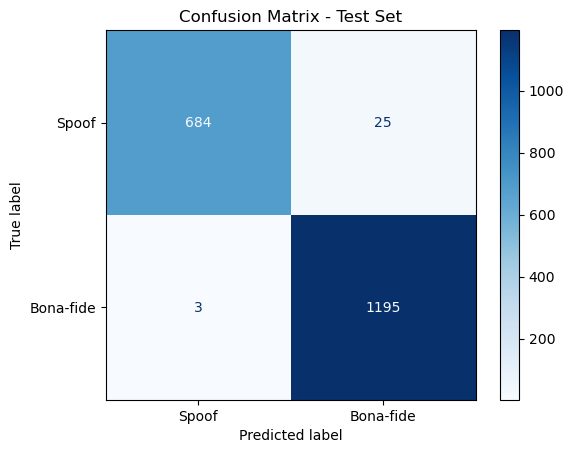

In [ ]:
def evaluate_on_test_set(model, test_dataset, batch_size=32, device='cuda' if torch.cuda.is_available() else 'cpu'):
    test_loader = DataLoader(test_dataset, batch_size=batch_size)
    model.eval()
    model.to(device)

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Testing"):
            inputs = [b.to(device) for b in batch[:-1]]
            labels = batch[-1].float().to(device).unsqueeze(1)

            outputs = model(*inputs)
            preds = (outputs > 0.5).int().cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds)
    rec = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)

    print("\nTest Set Evaluation:")
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1 Score:  {f1:.4f}")

    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Spoof", "Bona-fide"])
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix - Test Set")
    plt.show()

test_dataset = AudioFeatureDataset(
    meta_csv="datasets/release_in_the_wild/test_meta.csv",
    feature_root="datasets/release_in_the_wild/preprocessed_test",
    features=[
        'mfcc', 'chroma', 'tonnetz', 'spectral_contrast',
        'pitch', 'energy', 'zcr', 'onset_strength', 'spectral_centroid','mel_spectrogram'
    ]
)
evaluate_on_test_set(model, test_dataset)

